# Gamma Mixture Model

This notebook implements one of the experiments outlined in https://biaslab.github.io/publication/mp-based-inference-in-gmm/.

## Load packages

In [1]:
using Rocket, ReactiveMP, GraphPPL
using Distributions, Random
using StatsPlots

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1317


In [2]:
# create custom structure for model parameters for simplicity
struct GammaMixtureModelParameters
    nmixtures   # number of mixtures
    priors_as   # tuple of priors for variable a
    priors_bs   # tuple of priors for variable b
    prior_s     # prior of variable s
end

## Model specification

In [3]:
@model function gamma_mixture_model(nobservations, parameters::GammaMixtureModelParameters)

    # fetch information from struct
    nmixtures = parameters.nmixtures
    priors_as = parameters.priors_as
    priors_bs = parameters.priors_bs
    prior_s   = parameters.prior_s

    # set prior on global selection variable
    s ~ Dirichlet(probvec(prior_s))

    # allocate vectors of random variables
    as = randomvar(nmixtures)
    bs = randomvar(nmixtures)

    # set priors on variables of mixtures
    for i in 1:nmixtures
        as[i] ~ GammaShapeRate(shape(priors_as[i]), rate(priors_as[i]))
        bs[i] ~ GammaShapeRate(shape(priors_bs[i]), rate(priors_bs[i]))
    end

    # introduce random variables for local selection variables and data
    z = randomvar(nobservations)
    y = datavar(Float64, nobservations)

    # convert vector to tuples for proper functioning of GammaMixture node
    tas = tuple(as...)
    tbs = tuple(bs...)

    # specify local selection variable and data generating process
    for i in 1:nobservations
        z[i] ~ Categorical(s)
        y[i] ~ GammaMixture(z[i], tas, tbs)
    end

    # return random variables
    return s, as, bs, z, y
    
end

In [4]:
constraints = @constraints begin 
    q(as) :: PointMass(starting_point = (args...) -> [ 1.0 ])
end

Constraints:
	marginals form:
		q(as) :: PointMassFormConstraint() [ prod_constraint = ProdGeneric(ProdAnalytical()) ]
	messages form:
	factorisation:


In [5]:
# specify seed and number of data points
rng = MersenneTwister(43)
n_samples = 2500

# specify parameters of mixture model that generates the data
# Note that mixture components have exactly the same means
mixtures  = [ Gamma(9.0, inv(27.0)), Gamma(90.0, inv(270.0)) ]
nmixtures = length(mixtures)
mixing    = rand(rng, nmixtures)
mixing    = mixing ./ sum(mixing)
mixture   = MixtureModel(mixtures, mixing)

# generate data set
dataset = rand(rng, mixture, n_samples);

In [6]:
# specify priors of probabilistic model
# NOTE: As the means of the mixtures "collide", we specify informative prior for selector variable
nmixtures = 2
gpriors = GammaMixtureModelParameters(
    nmixtures,                                                    # number of mixtures
    [ Gamma(1.0, 0.1), Gamma(1.0, 1.0) ],                         # priors on variables a
    [ GammaShapeRate(10.0, 2.0), GammaShapeRate(1.0, 3.0) ],      # priors on variables b
    Dirichlet(1e3*mixing)                                         # prior on variable s
)

gmodel         = Model(gamma_mixture_model, length(dataset), gpriors)
gdata          = (y = dataset, )
ginitmarginals = (s = gpriors.prior_s, z = vague(Categorical, gpriors.nmixtures), bs = GammaShapeRate(1.0, 1.0))
greturnvars    = (s = KeepLast(), z = KeepLast(), as = KeepEach(), bs = KeepEach())

goptions = (
    limit_stack_depth     = 100, 
    default_factorisation = MeanField() # Mixture models require Mean-Field assumption currently
)

gresult = inference(
    model       = gmodel, 
    data        = gdata,
    constraints = constraints,
    options     = goptions,
    initmarginals = ginitmarginals,
    returnvars    = greturnvars,
    free_energy   = true,
    iterations    = 250, 
    showprogress  = true
);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


In [7]:
# extract inferred parameters
_as, _bs = mean.(gresult.posteriors[:as][end]), mean.(gresult.posteriors[:bs][end])
_dists   = map(g -> Gamma(g[1], inv(g[2])), zip(_as, _bs))
_mixing = mean(gresult.posteriors[:s])

# create model from inferred parameters
_mixture   = MixtureModel(_dists, _mixing);

In [8]:
# report on outcome of inference
println("Generated means: $(mean(mixtures[1])) and $(mean(mixtures[2]))")
println("Inferred means: $(mean(_dists[1])) and $(mean(_dists[2]))")
println("========")
println("Generated mixing: $(mixing)")
println("Inferred mixing: $(_mixing)")

Generated means: 0.3333333333333333 and 0.33333333333333337
Inferred means: 0.3333391655500223 and 0.3340894710148839
Generated mixing: [0.18923488676601088, 0.8107651132339891]
Inferred mixing: [0.11343753795629938, 0.8865624620437006]


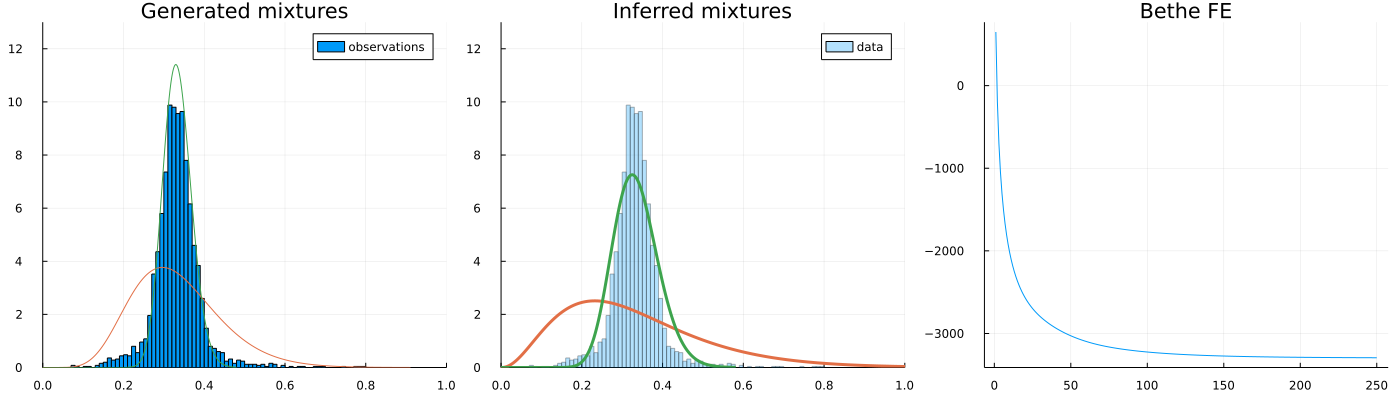

In [9]:
# plot results
p1 = histogram(dataset, ylim = (0, 13), xlim = (0, 1), normalize=:pdf, label="observations")
p1 = plot!(mixture, label=false, title="Generated mixtures")

p2 = histogram(dataset, ylim = (0, 13), xlim = (0, 1), normalize=:pdf, label="data", opacity=0.3)
p2 = plot!(_mixture, label=false, title="Inferred mixtures", linewidth=3.0)

# evaluate the convergence of the algorithm by monitoring the BFE
p3 = plot(gresult.free_energy, label=false, xlabel="iterations", title="Bethe FE")

plot(p1, p2, p3, layout = @layout([ a b c ]), size=(1400, 400))